In [1]:
# Read simulator images from udacity training set
import csv
import numpy as np
import cv2

import warnings
warnings.filterwarnings("ignore")

lines = []
with open('data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        lines.append(line)

# Create training set
images = []
measurements = []

for line in lines:
    # csv format: center,left,right,steering,throttle,brake,speed
    source_path_center = line[0]
    source_path_left = line[1]
    source_path_right = line[2]

    center_path = 'data/' + source_path_center # Updated pathnames
    left_path = 'data/' + source_path_left
    right_path = 'data/' + source_path_right

    center_image = cv2.imread(center_path) # Read in images
    left_image = cv2.imread(left_path)
    right_image = cv2.imread(right_path)

    if center_image is not None: # Create dataset using images/steering angles from each camera
        images.append(center_image)
        measurements.append(float(line[3]) * 1.05)
    if left_image is not None:
        images.append(left_image)
        measurements.append(float(line[3]) * 0.2)
    if right_image is not None:
        images.append(right_image)
        measurements.append(float(line[3]) * -0.2)

X_train = np.array(images)
y_train = np.array(measurements)


/home/carnd/anaconda3/lib/python3.5/site-packages/matplotlib/font_manager.py:1288: UserWarning: findfont: Font family ['monospace'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))


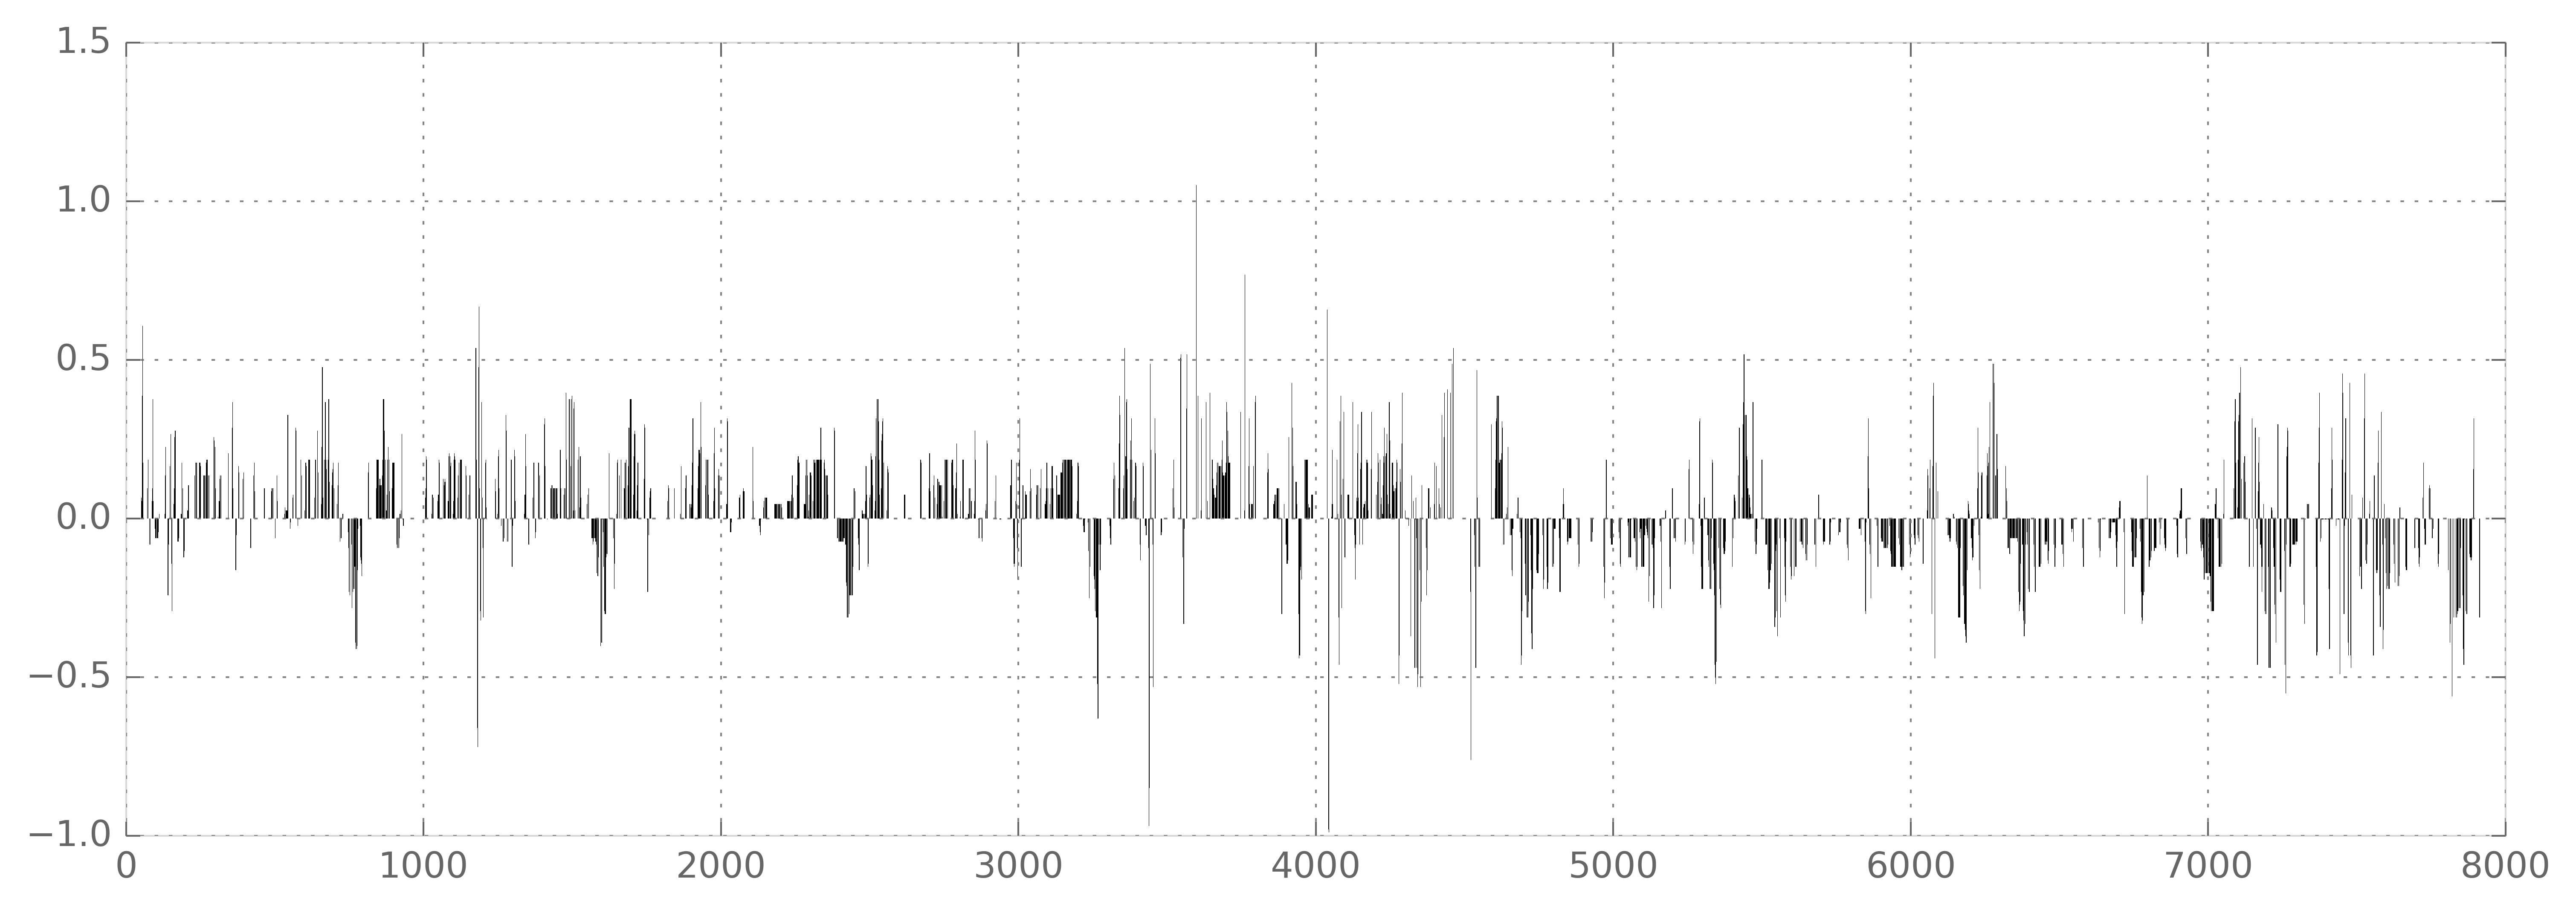

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

# Check training set angles 
plt.figure(figsize=(12, 4))
plt.bar(range(len(y_train)), y_train, color='k')
plt.xlim(0,8000)
plt.show()

In [3]:
# Model based on https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/
# Using keras
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers import Dropout, Dense, Lambda, Cropping2D, Activation, Flatten

model = Sequential()

# pre process as described in lecture
# 1. Normalize input data
model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(160,320,3))) 

# 2. Crop 70 pixels off the top and 20 pixels off the bottom of images
model.add(Cropping2D(cropping=((70,20),(0,0)))) 

Using TensorFlow backend.


In [4]:
#model.add(Convolution2D(3, 1, 1, border_mode='valid', activation='relu', 
#                        input_shape=(32, 32, 3)))
model.add(Conv2D(3, (1, 1), padding="valid", activation="relu", input_shape=(32, 32, 3)))
model.add(Conv2D(6, (3, 3), border_mode='valid', activation='relu'))
model.add(Conv2D(12, (5, 5), border_mode='valid', subsample=(2,2), activation='relu'))
model.add(Conv2D(16, (5, 5), border_mode='valid', subsample=(2,2), activation='relu'))

model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

# train model
#model.fit_generator(read_data(batch_size), samples_per_epoch=16000, nb_epoch=5)
model.fit(X_train, y_train, validation_split=0.2, shuffle=True, epochs=5)
model.save('model.h5')

/home/carnd/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(6, (3, 3), activation="relu", padding="valid")`
/home/carnd/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(12, (5, 5), activation="relu", strides=(2, 2), padding="valid")`
/home/carnd/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (5, 5), activation="relu", strides=(2, 2), padding="valid")`


Train on 6428 samples, validate on 1608 samples
Epoch 1/5
6428/6428 [==============================] - 38s - loss: 0.0119 - acc: 0.5404 - val_loss: 0.0125 - val_acc: 0.5516
Epoch 2/5
6428/6428 [==============================] - 35s - loss: 0.0101 - acc: 0.5404 - val_loss: 0.0124 - val_acc: 0.5516
Epoch 3/5
6428/6428 [==============================] - 35s - loss: 0.0089 - acc: 0.5404 - val_loss: 0.0129 - val_acc: 0.5516
Epoch 4/5
6428/6428 [==============================] - 35s - loss: 0.0069 - acc: 0.5404 - val_loss: 0.0129 - val_acc: 0.5516
Epoch 5/5
6428/6428 [==============================] - 35s - loss: 0.0046 - acc: 0.5404 - val_loss: 0.0126 - val_acc: 0.5516
